# Child in Need Plan (CiNP) - Demographic Analysis

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
plt.style.use('tableau-colorblind10')
color='#702A7D'
grey_color = '#A9A9A9'


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

In [2]:
cinp_query = """
SELECT
  a.person_id, a.YearOfBirth
  ,a.PCArea, a.EthnicOrigin
  ,a.StartDate, a.EndDate
  ,p.birth_datetime AS DateOfBirth
  ,p.gender_source_value AS Gender
FROM
    yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiNP AS a
LEFT JOIN
    yhcr-prd-bradfor-bia-core.CB_2649.person AS p
ON
    a.person_id = p.person_id
"""

In [3]:
cinp = pandas_gbq.read_gbq(cinp_query)
cinp.info()

Downloading: 100%|██████████|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5749 entries, 0 to 5748
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     5749 non-null   object             
 1   YearOfBirth   5749 non-null   Int64              
 2   PCArea        5749 non-null   object             
 3   EthnicOrigin  5749 non-null   object             
 4   StartDate     5749 non-null   dbdate             
 5   EndDate       4322 non-null   dbdate             
 6   DateOfBirth   5733 non-null   datetime64[us, UTC]
 7   Gender        5736 non-null   object             
dtypes: Int64(1), datetime64[us, UTC](1), dbdate(2), object(4)
memory usage: 365.1+ KB


# Import Project functions

In [4]:
import sys
sys.path.append('../code')

from data_cleaning import fill_missing_dob, convert_dates_datatype, drop_duplicates, gender_mapping

from analysis_helpers import (
    analyse_person_ids,
    add_calculated_columns,
    plot_distributions,
    plot_age_distribution,
    plot_monthly_trends,
    plot_monthly_entries_exits,
    plot_running_total_in_intervention,
    plot_duration_in_intervention,
    plot_average_duration_by_age,
    plot_median_duration_by_age,
    plot_median_intervention_duration_over_time
)

In [5]:
# Fill Missing DoB
cinp = fill_missing_dob(cinp, 'YearOfBirth', 'DateOfBirth')

# Convert Date columns datatype
date_columns = ['StartDate', 'DateOfBirth', 'EndDate']
cinp = convert_dates_datatype(cinp, date_columns)

# Drop duplicates
drop_duplicates(cinp)

# Clean Gender column
gender_mapping(cinp, 'Gender')

# Remove the only 1 data point of December 2021
cinp = cinp.loc[~(cinp['EndDate'] > '2021-11-30')]

# Add calculated columns
cinp = add_calculated_columns(cinp)

cinp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5746 entries, 0 to 5748
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   person_id                    5746 non-null   object        
 1   YearOfBirth                  5746 non-null   Int64         
 2   PCArea                       5746 non-null   object        
 3   EthnicOrigin                 5746 non-null   object        
 4   StartDate                    5746 non-null   datetime64[ns]
 5   EndDate                      4319 non-null   datetime64[ns]
 6   DateOfBirth                  5746 non-null   datetime64[us]
 7   Gender                       5720 non-null   object        
 8   AgeAtEntry                   5746 non-null   int64         
 9   num_of_days_in_intervention  4319 non-null   Int64         
 10  entry_agegroup               4984 non-null   category      
dtypes: Int64(2), category(1), datetime64[ns](2), dat

## Exploratory Analysis

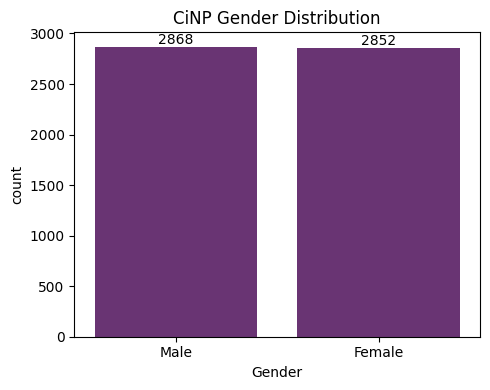

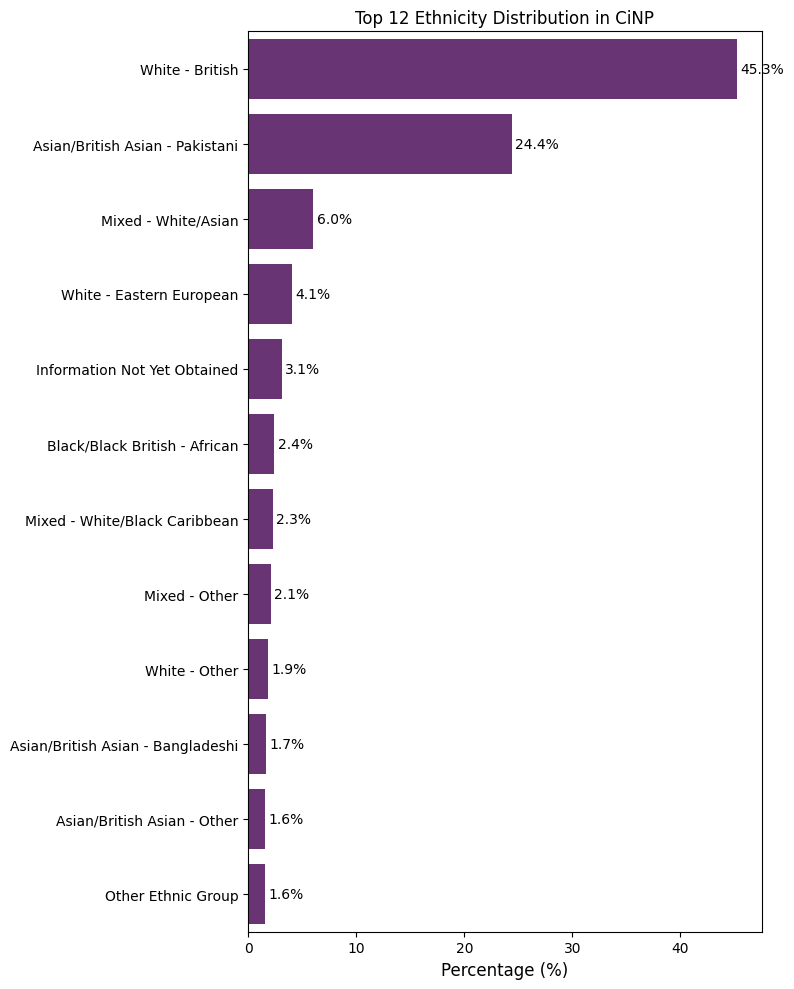

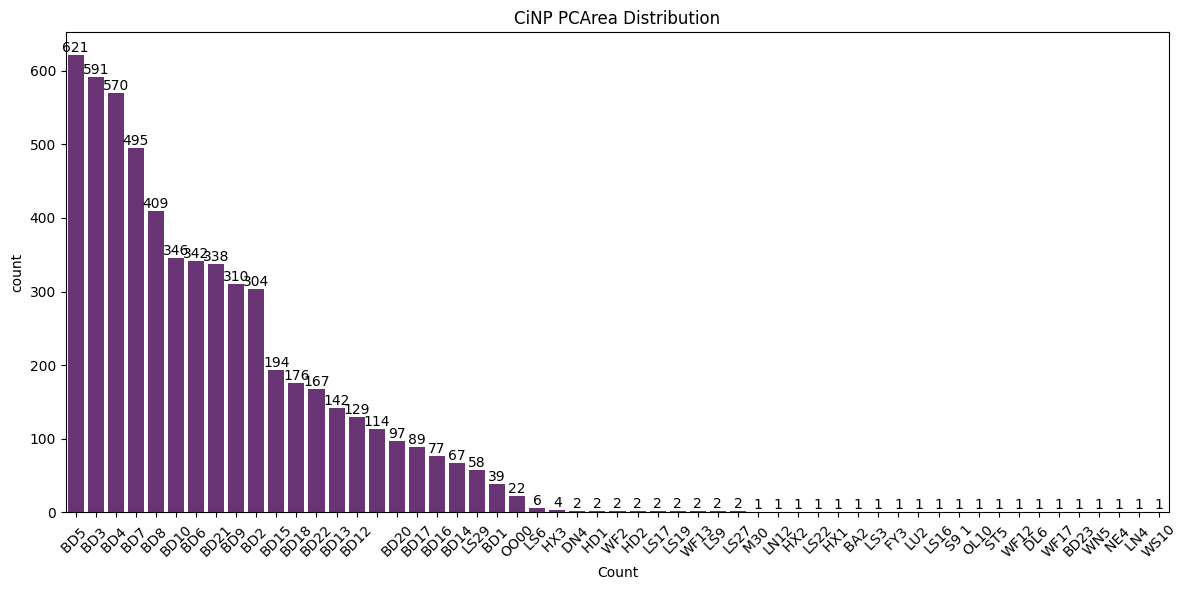

In [6]:
# Plot Categorical Distributions
plot_distributions(cinp, 'CiNP')

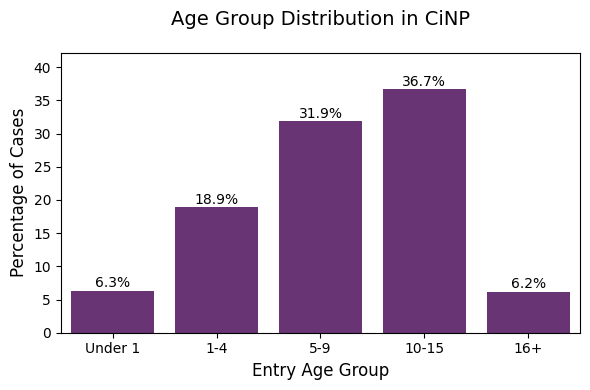

In [7]:
# Plot age distribution
plot_age_distribution(cinp, 'CiNP')

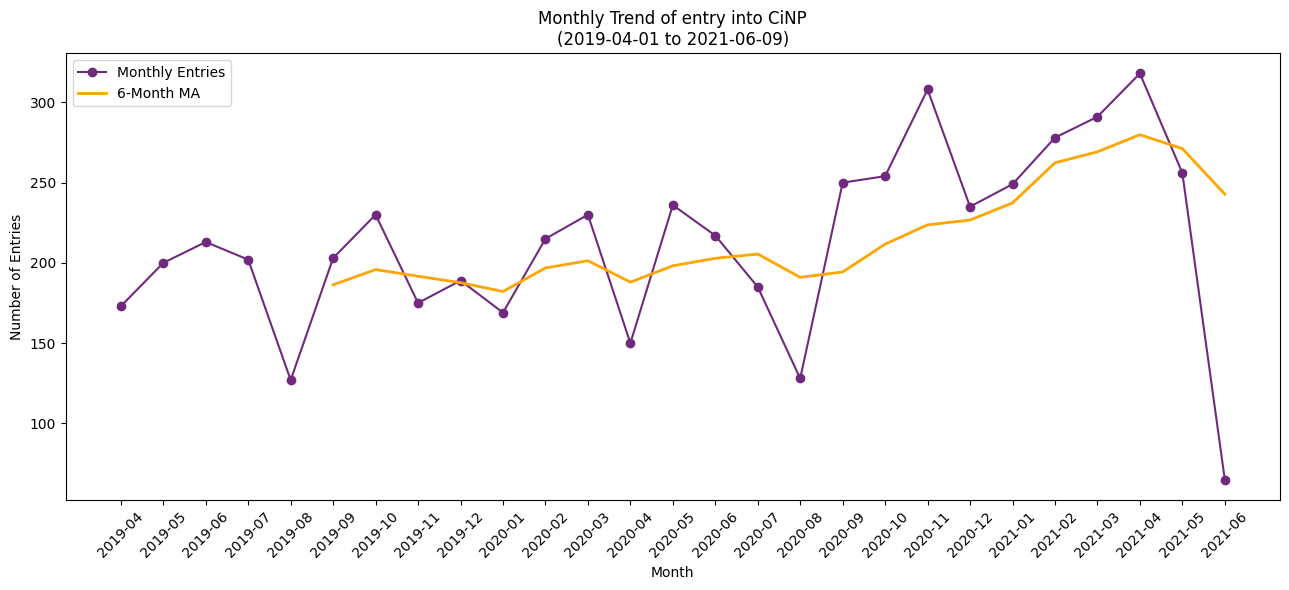

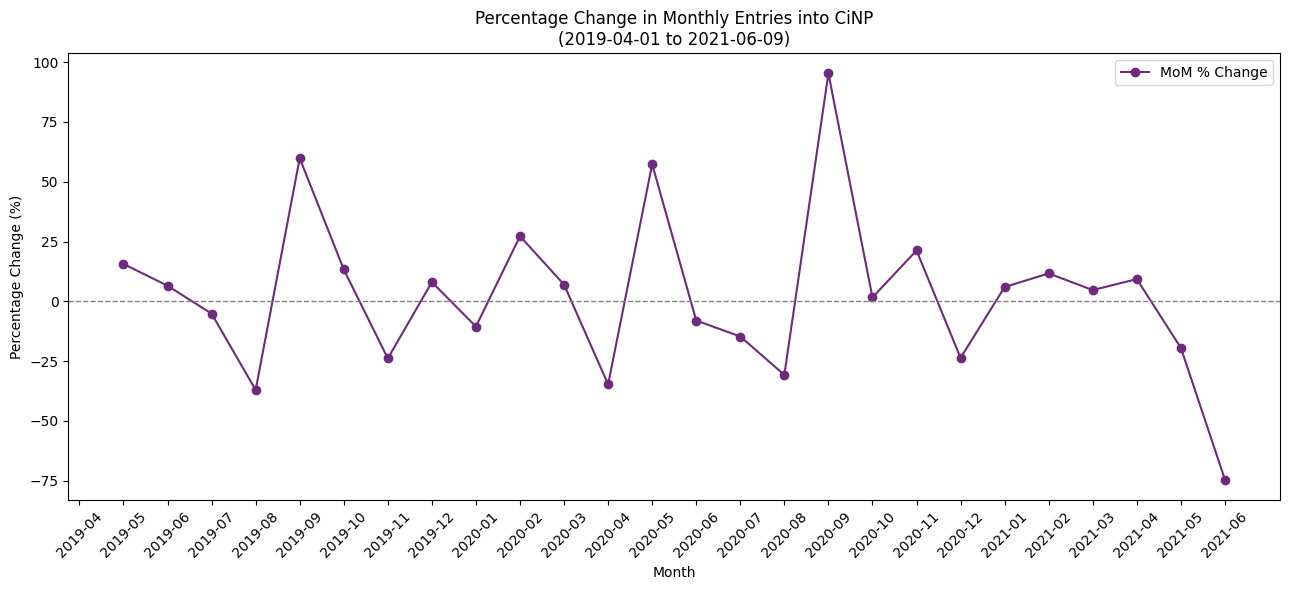

In [8]:
# Plot monthly trends
plot_monthly_trends(cinp, 'CiNP', 'StartDate')

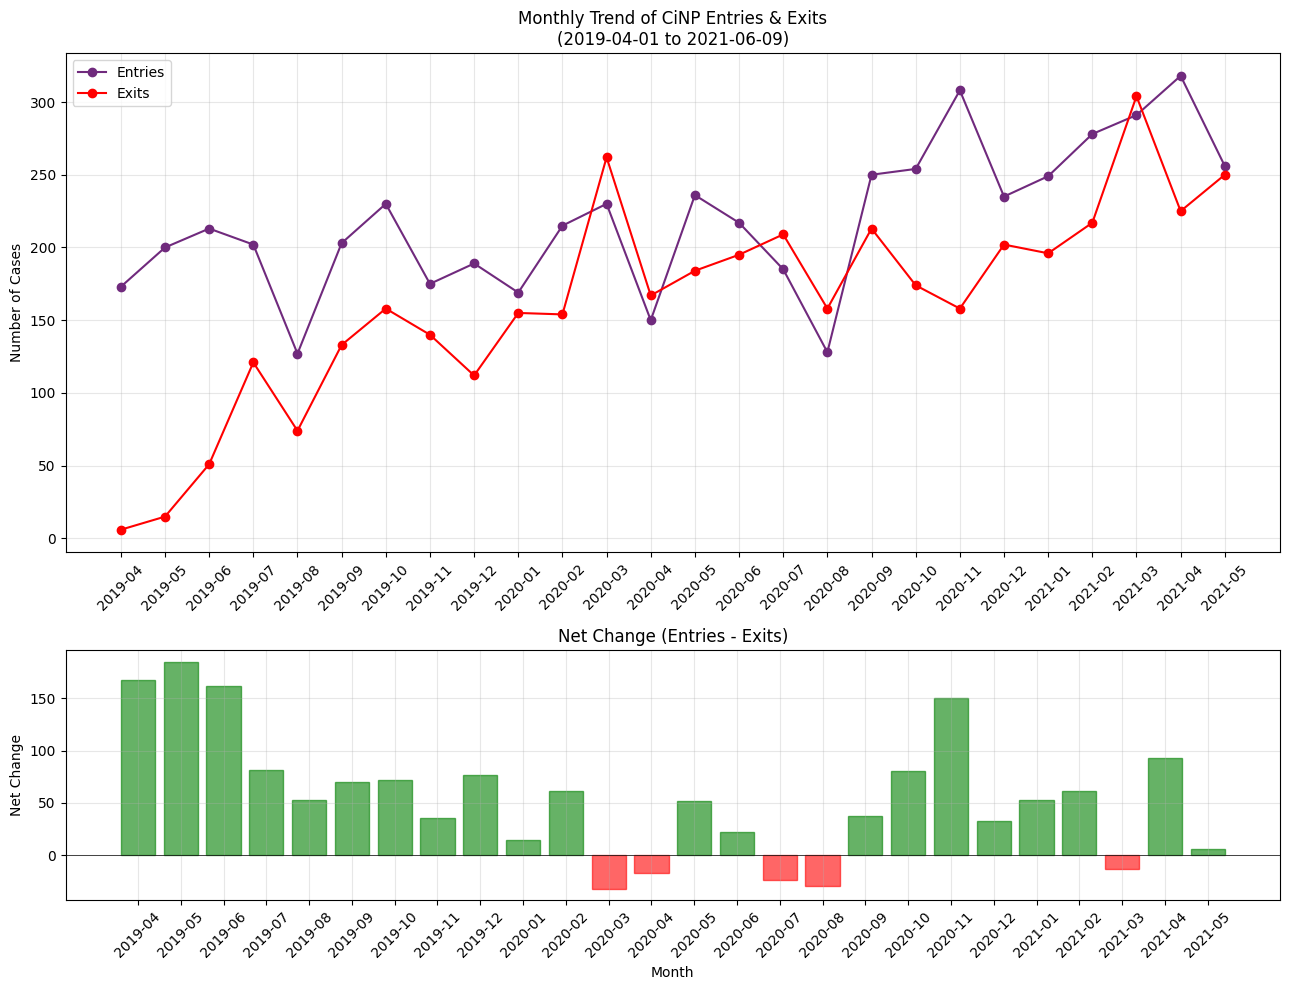


Summary of Net Changes for CiNP:
Average monthly net change: 55.7
Maximum increase: 185
Maximum decrease: -32
Months with net increase: 21
Months with net decrease: 5


In [9]:
# Plot monthly ebtries and exits trends
plot_monthly_entries_exits(cinp, 'StartDate', 'EndDate', 'CiNP')

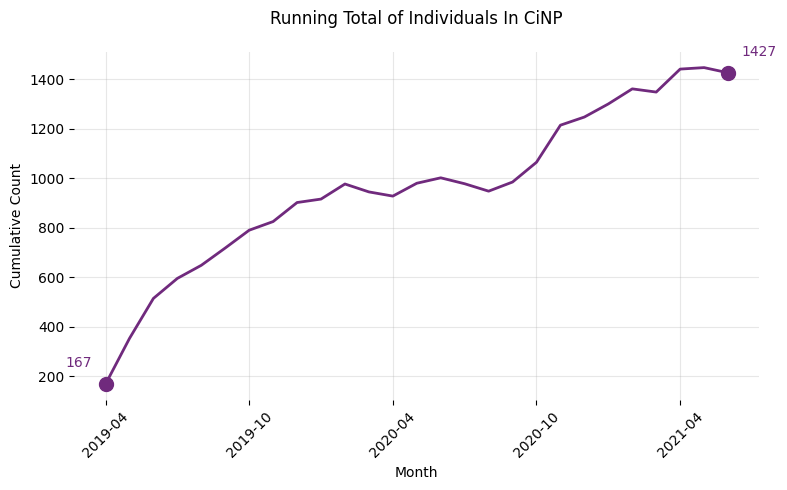

In [10]:
# Plot demand in intervention
plot_running_total_in_intervention(cinp, 'StartDate', 'EndDate', 'CiNP')

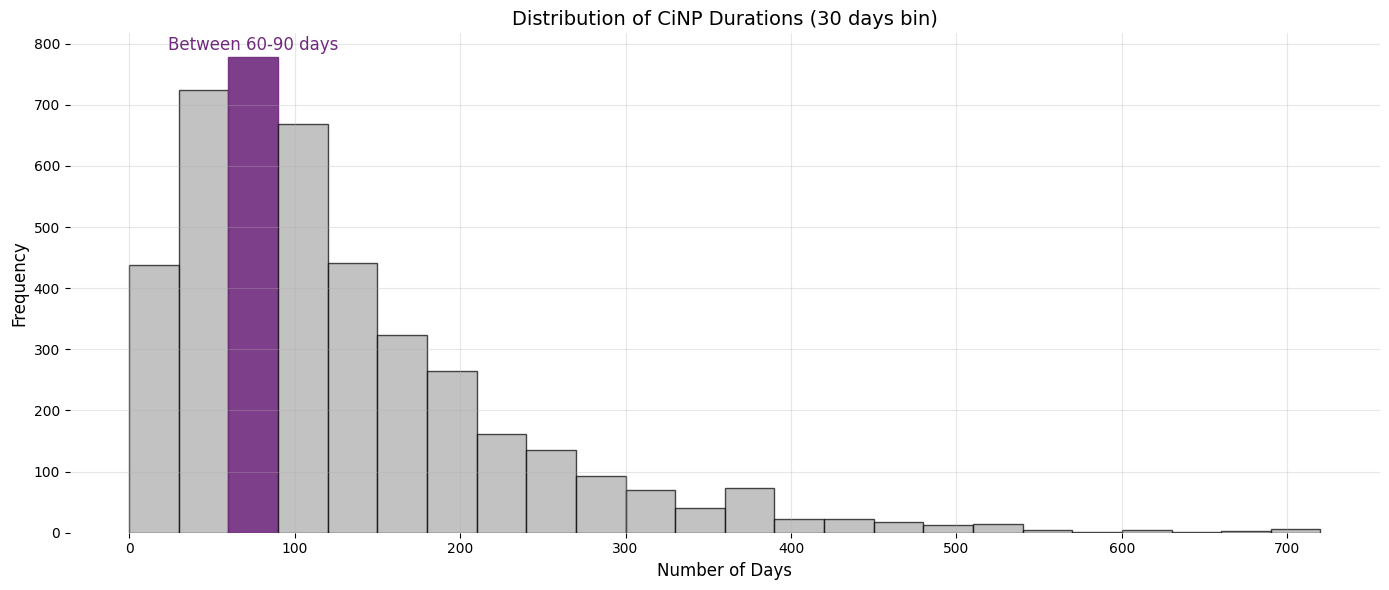

In [11]:
# Plot duration in intervention
plot_duration_in_intervention(cinp, 'StartDate', 'EndDate', 'CiNP')

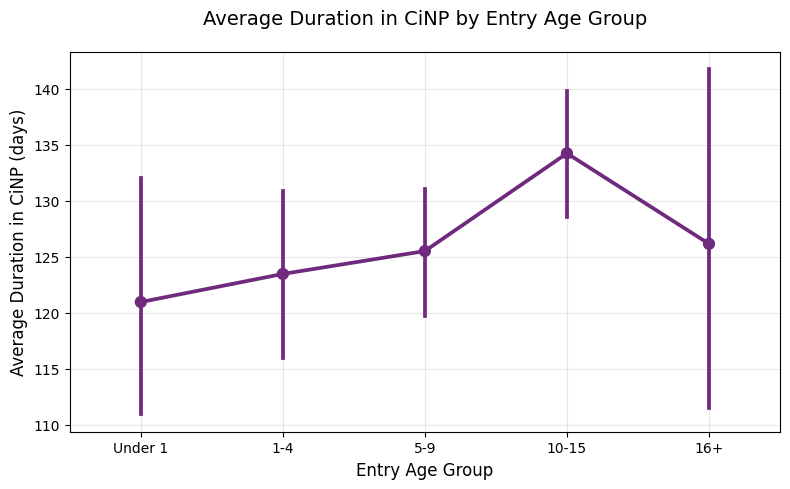

In [12]:
# # Plot average duration in intervention
plot_average_duration_by_age(cinp, 'CiNP')

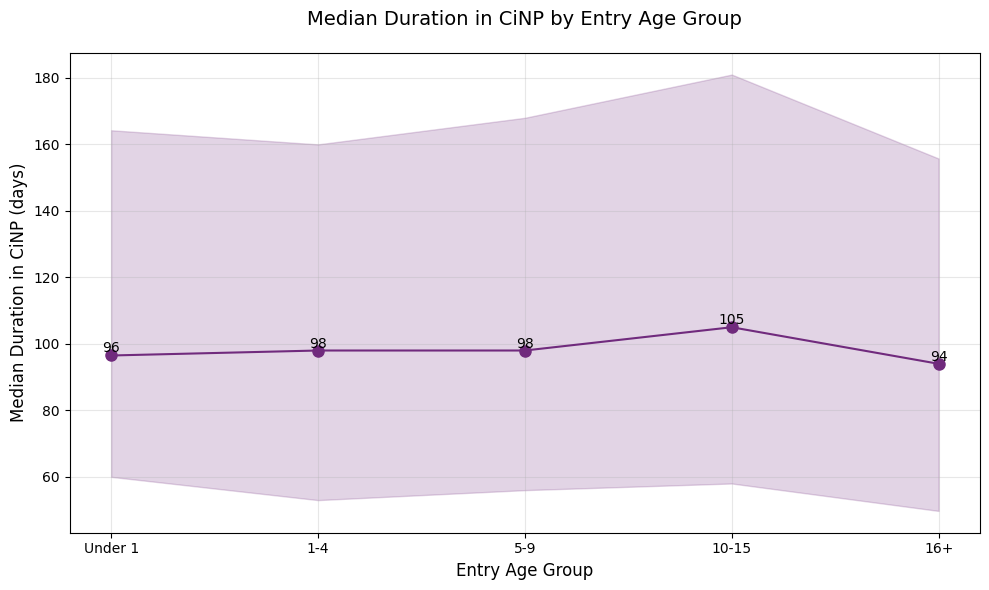

In [13]:
# Plot median duration by age group
plot_median_duration_by_age(cinp, 'CiNP')

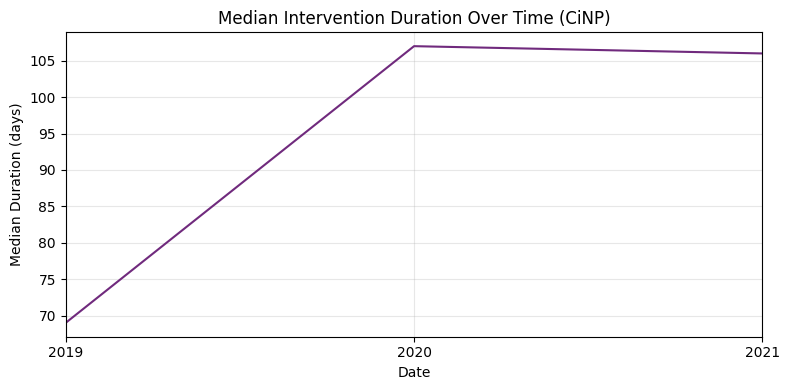

In [14]:
# Plot median duration over time
plot_median_intervention_duration_over_time(cinp, 'CiNP', 'EndDate',
                                                'num_of_days_in_intervention',
                                                time_freq='Y')